In [ ]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os
import json
from PIL import Image, ImageDraw
import shutil

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.2/645.2 kB 8.7 MB/s eta 0:00:00


In [ ]:
os.makedirs('datasets', exist_ok=True)
%cd datasets

/content/datasets


In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

download_file(
    'https://drive.google.com/uc?export=download&confirm=no_antivirus&id=1kfaFRem8bvWV_iZ2ZtSwRJIl7vP5MKNQ',
    'urban_dataset.zip'
)


In [ ]:
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('urban_dataset.zip')
%cd ..

Extracted all
/content


In [ ]:
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [ ]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [ ]:
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(18, 16))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(3, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()


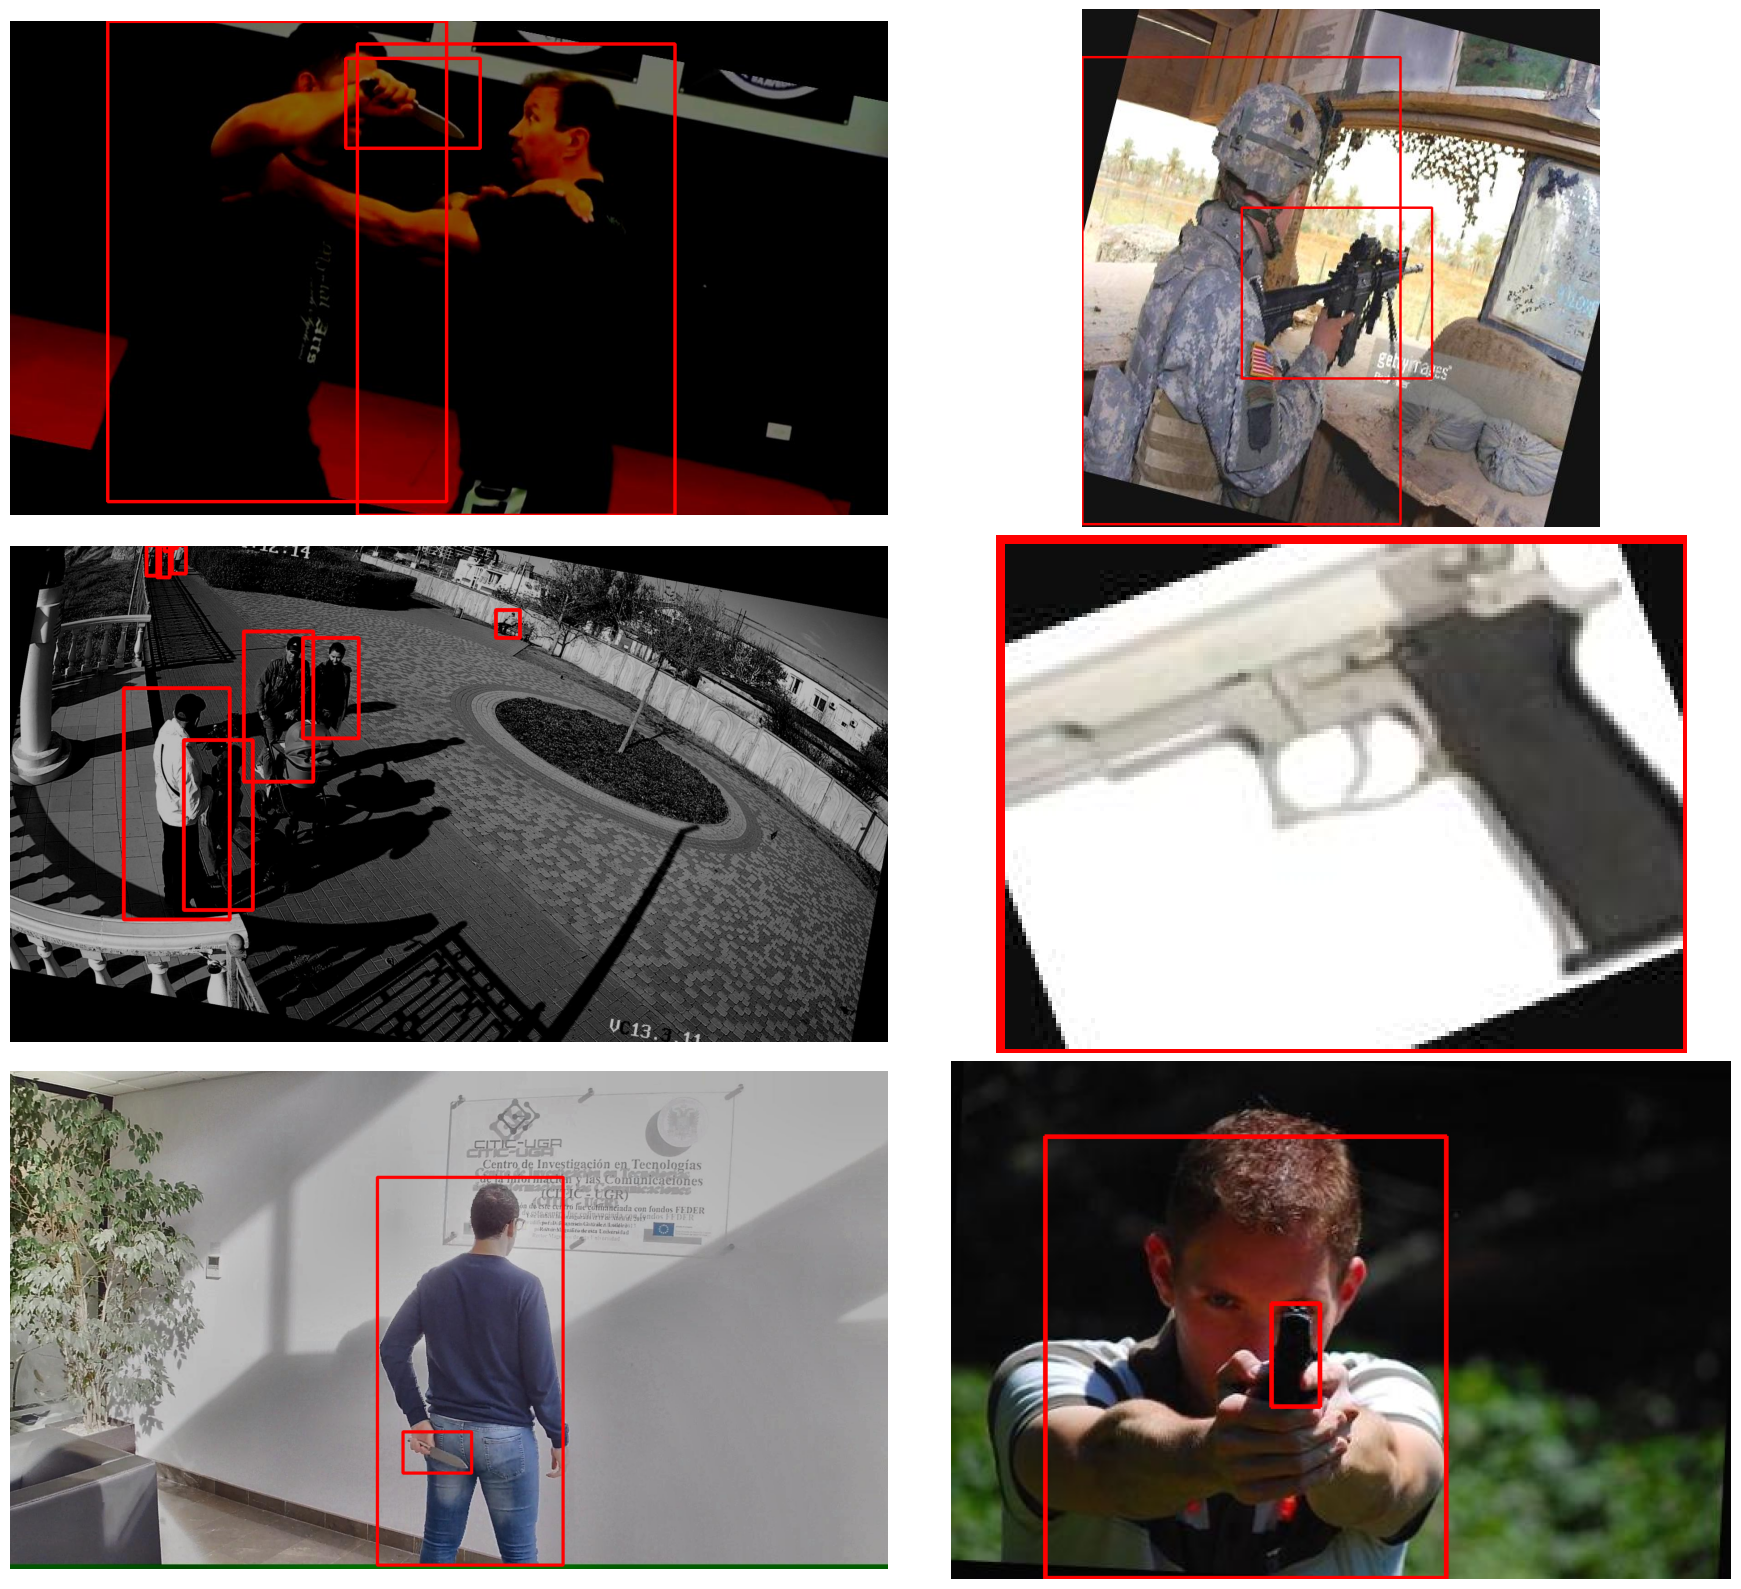

In [ ]:
# Visualize a few training images.
plot(
    image_paths='datasets/train/images/',
    label_paths='datasets/train/labels/',
    num_samples=6,
)

In [ ]:
!yolo task=detect mode=train model=yolov8s.pt data='/content/datasets/data.yaml' epochs=64 augment=True optimizer='AdamW' lr0=.0015 augment=True batch=64 patience = 8 dropout=.1  name=yolov8s_custom

100% 49.7M/49.7M [00:00<00:00, 286MB/s]
Ultralytics YOLOv8.0.207 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/content/datasets/data.yaml, epochs=50, patience=5, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8m_custom, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=True, agnostic_nms=False, classes=None, retina_masks=False, 

In [ ]:
!yolo task=detect mode=val model=runs/detect/yolov8s_custom/weights/best.pt name=yolov8s_eval data='/content/datasets/data.yaml'

Ultralytics YOLOv8.0.207 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25842655 parameters, 0 gradients, 78.7 GFLOPs
val: Scanning /content/datasets/valid/labels.cache... 775 images, 0 backgrounds, 0 corrupt: 100% 775/775 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 49/49 [00:19<00:00,  2.49it/s]
                   all        775       1443      0.868      0.754      0.816      0.552
                 knife        775        150      0.882        0.9      0.886      0.553
          long_weapons        775         84      0.863      0.602      0.667       0.44
       man_with_weapon        775        301      0.822      0.798      0.866      0.583
    man_without_weapon        775        312       0.85      0.616      0.743      0.464
         short_weapons        775        596      0.924      0.854      0.918      0.719
Speed: 0.5ms preprocess, 17.1ms inference, 0.0ms 

In [ ]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8s_custom/weights/best.pt \
source=datasets/test/images \
name=yolov8s_custom_finish \
#hide_labels=False

Ultralytics YOLOv8.0.207 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 218 layers, 25842655 parameters, 0 gradients, 78.7 GFLOPs

image 1/531 /content/datasets/test/images/1-113-_jpg.rf.460fe8afc8ea1407517d5379863b9a16.jpg: 640x640 1 short_weapons, 36.9ms
image 2/531 /content/datasets/test/images/1-124-_jpg.rf.080ec034d863d361e94156f1f87607c9.jpg: 640x640 1 long_weapons, 36.9ms
image 3/531 /content/datasets/test/images/1-127-_jpg.rf.52065bea79eb66e096cd9bdebf5811e6.jpg: 640x640 1 short_weapons, 36.9ms
image 4/531 /content/datasets/test/images/1-140-_jpg.rf.46b56570a64d8996097f1bd3d0859679.jpg: 640x640 1 short_weapons, 27.7ms
image 5/531 /content/datasets/test/images/1-150-_jpg.rf.3b03e59a952e043487a6fb863fa57555.jpg: 640x640 1 short_weapons, 27.7ms
image 6/531 /content/datasets/test/images/1-155-_jpg.rf.b136dface96f573d3c46aa0386f6fa95.jpg: 640x640 1 short_weapons, 27.6ms
image 7/531 /content/datasets/test/images/1-157-_jpg.rf.3280a973b945bc377c5

In [ ]:
img=Image.open("/content/runs/detect/yolov8s_custom2/results.png")
plt.figure(figsize=(10, 10))
plt.imshow(img, interpolation='bicubic')
plt.show()